# Imports

In [ ]:
import rasterio
import rasterio.warp
import rasterio.mask
import matplotlib.pyplot as plt
import fiona
import numpy as np
import shapely 
from shapely.ops import unary_union
from shapely import affinity
from shapely import Polygon, MultiPolygon, box 
#from skimage.measure import block_reduce
import json

In [ ]:
from utilities.area import show_stats, get_scales
from utilities.geojson import filter_features, filter_features_by_list, get_polygons

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

United Kingdom

In [ ]:
london_boroughs = [
    'City of London', 'Westminster', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Wandsworth', 'Lambeth',
    'Southwark', 'Tower Hamlets', 'Hackney', 'Islington', 'Camden', 'Brent', 'Ealing', 'Hounslow', 'Richmond upon Thames',
    'Kingston upon Thames', 'Merton', 'Sutton', 'Croydon', 'Bromley', 'Lewisham', 'Greenwich', 'Bexley', 'Havering',
    'Barking and Dagenham', 'Redbridge', 'Newham', 'Waltham Forest','Haringey', 'Enfield', 'Barnet', 'Harrow',
    'Hillingdon'
]
inner_city_boroughs = [
    'Islington', 'Camden', 'Westminster', 'Southwark', 'Tower Hamlets', 'Hackney', 'Lambeth'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-GBR-ADM2-all/geoBoundaries-GBR-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
london_borough_features = filter_features_by_list(shape_data, 'shapeName', london_boroughs)
london_borough_boundaries = get_polygons(london_borough_features, mainland=True)
inner_city_borough_features = filter_features_by_list(shape_data, 'shapeName', inner_city_boroughs)
inner_city_borough_boundaries = get_polygons(inner_city_borough_features, mainland=True)
city_of_london_features = filter_features(shape_data, 'shapeName', 'City of London')
city_of_london_boundary = get_polygons(city_of_london_features, mainland=True)['City of London']

region_polygons = london_borough_boundaries
admin_polygons = inner_city_borough_boundaries

South Africa

In [ ]:
city_of_joburg_data = fiona.open("data/2018_Regions_CoJ/2018_Regions.shp", "r")
polygons = get_polygons(city_of_joburg_data, identifier='REGION_NAM')
coj_proj = rasterio.warp.transform_geom(
    city_of_joburg_data.crs,
    rasterio.crs.CRS.from_epsg(4326),
    polygons.values()
)
admin_polygons = dict((name, Polygon(geom['coordinates'][0])) for name, geom in zip(polygons.keys(), coj_proj))
region_polygons = admin_polygons

France

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end=', ')

In [ ]:
paris_departments = [
    'Paris', 'Val-de-Marne', 'Hauts-de-Seine', 'Seine-Saint-Denis'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-FRA-ADM2-all/geoBoundaries-FRA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
paris_department_features = filter_features_by_list(shape_data, 'shapeName', paris_departments)
paris_department_polygons = get_polygons(paris_department_features, mainland=True)
    
paris_feature = filter_features(shape_data, 'shapeName', 'Paris')
paris_polgyon = get_polygons(paris_feature, mainland=True)['Paris']

region_polygons = paris_department_polygons
admin_polygons = paris_department_polygons # [paris_polgyon]

Netherlands

In [ ]:
geojson_filepath = 'data/geoBoundaries-NLD-ADM1-all/geoBoundaries-NLD-ADM1.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    
holland_features = filter_features_by_list(shape_data, 'shapeName', ['Noord-Holland', 'Zuid-Holland'])
admin_polygons = get_polygons(holland_features, mainland=True)
region_polygons = get_polygons(shape_data['features'], mainland=True)

Philipines

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end='; ')

In [ ]:
manila_divisons = [
    'NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'
]

In [ ]:
geojson_filepath = 'data/geoBoundaries-PHL-ADM2-all/geoBoundaries-PHL-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
manila_divison_features = filter_features_by_list(shape_data, 'shapeName', manila_divisons)
print(len(manila_divison_features))
manila_divison_polygons = get_polygons(manila_divison_features, mainland=True)
    
region_polygons = manila_divison_polygons
admin_polygons = manila_divison_polygons

New York, USA

- change second 'Richmond' to 'Richmond, NY'
- change second 'Kings' to 'Kings, NY'

In [ ]:
# for feat in shape_data['features']:
#     print(feat['properties']['shapeName'], end='; ')

In [ ]:
geojson_filepath = 'data/geoBoundaries-USA-ADM2-all/geoBoundaries-USA-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)

In [ ]:
new_york_counties = ['New York', 'Bronx', 'Kings, NY', 'Queens', 'Richmond, NY']

In [ ]:
new_york_feature = filter_features_by_list(shape_data, 'shapeName', new_york_counties)
new_york_polygon = get_polygons(new_york_feature)

region_polygons = new_york_polygon
admin_polygons = new_york_polygon 

Israel

In [ ]:
geojson_filepath = 'data/geoBoundaries-ISR-ADM2-all/geoBoundaries-ISR-ADM2.geojson'
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
admin_polygons = get_polygons(shape_data['features'], mainland=True)
region_polygons = admin_polygons

### Plotting

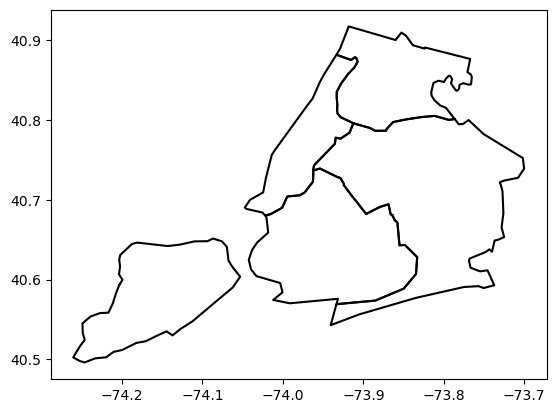

In [ ]:
fig, ax = plt.subplots()
for idx, shape in enumerate(region_polygons.values()):
    if isinstance(shape, Polygon):
        polygon = shape
        xs, ys = polygon.exterior.coords.xy
        ax.plot(xs, ys, 'k-')
    elif isinstance(shape, MultiPolygon):
        for polygon in shape.geoms:
            xs, ys = polygon.exterior.coords.xy
            ax.plot(xs, ys, 'k-')
    else:
        print(f'Shape at idx {idx} is of type {type(shape)} is not supported')
ax.plot();

In [ ]:
region_polygon = unary_union(list(region_polygons.values()))

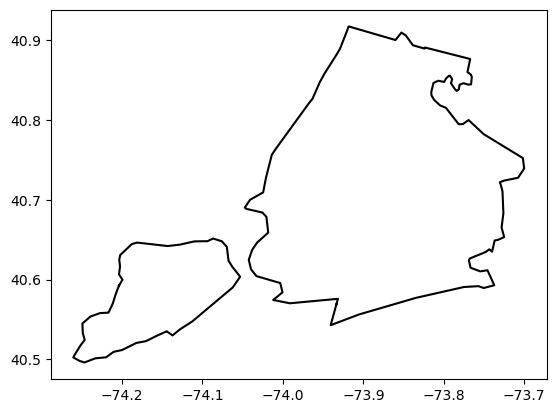

In [ ]:
fig, ax = plt.subplots()
if isinstance(region_polygon, Polygon):
    xs, ys = region_polygon.exterior.coords.xy
    ax.plot(xs, ys, 'k-');
elif isinstance(region_polygon, MultiPolygon):
    for polygon in region_polygon.geoms:
        xs, ys = polygon.exterior.coords.xy
        ax.plot(xs, ys, 'k-');

## Population Data

https://rasterio.readthedocs.io/en/latest/quickstart.html

https://hub.worldpop.org/geodata/listing?id=78

In [ ]:
#raster_filepath = 'data/gbr_ppp_2020_constrained.tif' # Great Britain count / 100m
#raster_filepath = 'data/gbr_pd_2020_1km_UNadj.tif' # Great Britain density / 1km
#raster_filepath = 'data/zaf_ppp_2020_constrained.tif' # South Africa  / 100m
#raster_filepath = 'data/fra_ppp_2020_constrained.tif' # France  / 100m
#raster_filepath = 'data/nld_ppp_2020_constrained.tif' # Netherlands  / 100m
#raster_filepath = 'data/phl_ppp_2020_constrained.tif' # Philipines  / 100m
raster_filepath = 'data/usa_ppp_2020_constrained.tif' # USA  / 100m
#raster_filepath = 'data/isr_ppp_2020_constrained.tif' # Israel  / 100m
dataset = rasterio.open(raster_filepath)

In [ ]:
print(dataset.name)
print('No. of bands:', dataset.count)
print(f'height: {dataset.height} ; width: {dataset.width}')
print(dataset.bounds)
print('Upper left: ', dataset.transform * (0, 0))
print('Lower right:', dataset.transform * (dataset.width, dataset.height))
print('Co-ordinate reference system:', dataset.crs)
print(dataset.profile)

data/usa_ppp_2020_constrained.tif
No. of bands: 1
height: 62976 ; width: 430711
BoundingBox(left=-179.147915935, bottom=18.91041679192, right=179.77791596263003, top=71.390416582)
Upper left:  (-179.147915935, 71.390416582)
Lower right: (179.77791596263003, 18.91041679192)
Co-ordinate reference system: EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 430711, 'height': 62976, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00083333333, 0.0, -179.147915935,
       0.0, -0.00083333333, 71.390416582), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
#img = dataset.read(1)

In [ ]:
## Can be Very slow
# img[img<0] = 1
# img = np.log10(img+1)
# img[img==0] = np.nan

# fig, ax = plt.subplots()
# cax = ax.imshow(img)

## Clip to region of intersest

https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

In [ ]:
with rasterio.open(raster_filepath) as src:
    region_image, region_transform = rasterio.mask.mask(src, [region_polygon], crop=True)
    region_image[region_image < 0] = 0

In [ ]:
img = region_image[0, :, :]
print(img.max())
print(img.sum())

2676.6382
8333367.0


In [ ]:
# img_downscaled = block_reduce(img, block_size=10, func=np.sum)
# print(img.sum(), img_downscaled.sum(), img_downscaled.sum()/img.sum())

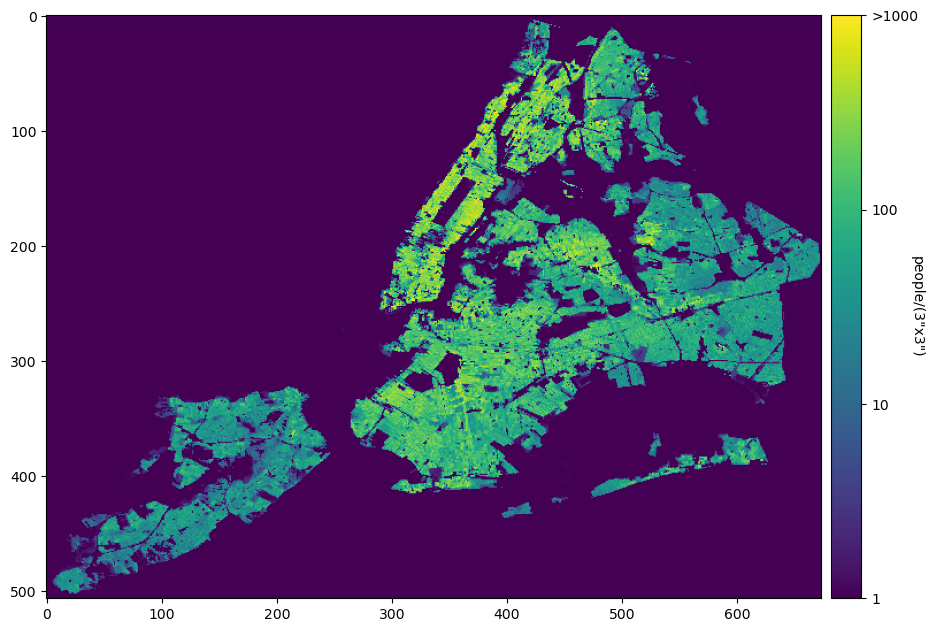

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
vmax = np.log10(1_000)

cmap = plt.get_cmap('viridis')#, 10)
axis_image = ax.imshow(np.log10(img + 1), vmax=vmax, cmap=cmap)
#fig.colorbar(axis_image)

cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = fig.colorbar(axis_image, cbar_axis)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) # counts

ticks = np.log10([1, 10, 100, 1_000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

scales

In [ ]:
earth_radius = 6378137 # metres
height, width = img.shape
long_min, lat_min, long_max, lat_max = region_polygon.bounds
print(3600 * (long_max - long_min) / width) # arc seconds / pixel
print(3600 * (lat_max - lat_min) / height) # arc seconds / pixel
long_scale, lat_scale = get_scales(img.shape, region_polygon)
print(f'{long_scale:.2f} m/pixel') 
print(f'{lat_scale:.2f} m/pixel') 

2.9942554807121944
2.9927154674556764
92.54 m/pixel
70.19 m/pixel


units on axis

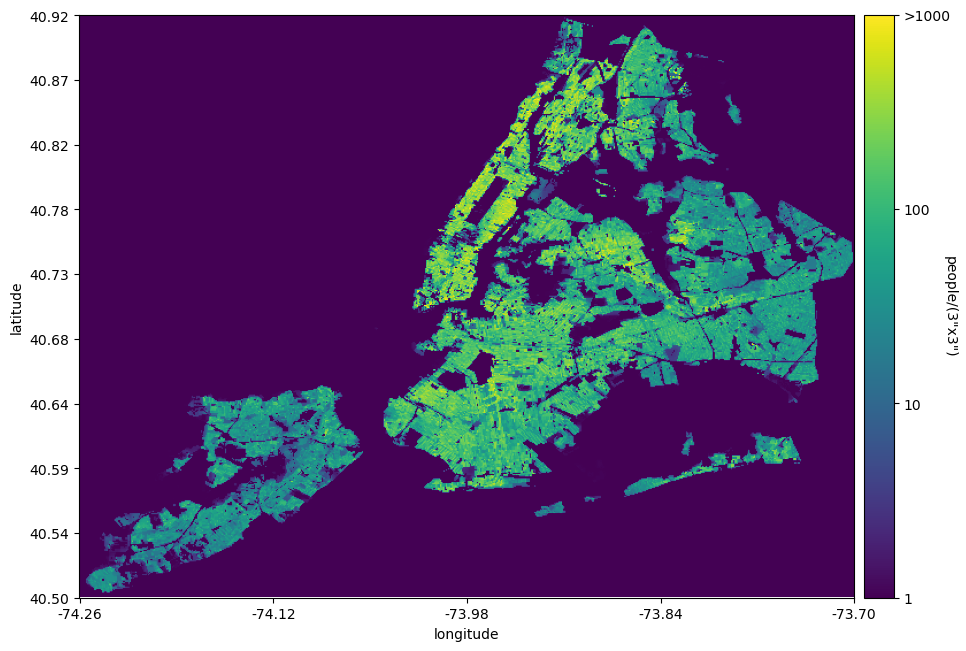

In [ ]:
## long / lat
long_min, lat_max = region_transform * (0, 0)
long_max, lat_min = region_transform * (width, height)
num_steps = 10
x_ticks = np.linspace(0, width, 5)
x_ticklabels = [f'{x:.2f}' for x in np.linspace(long_min, long_max, 5)]
y_ticks = np.linspace(0, height, num_steps)
y_ticklabels = reversed([f'{x:.2f}' for x in np.linspace(lat_min, lat_max, num_steps)])
x_unit = 'longitude'
y_unit = 'latitude'

### km
# x_ticklabels = np.arange(0, lat_scale * width, 10_000)
# x_ticks = np.floor(x_ticklabels / lat_scale)
# x_ticklabels /= 1000
# y_ticklabels = np.arange(0, long_scale * height, 10_000)
# y_ticks = np.floor(y_ticklabels / long_scale)
# y_ticklabels /= 1000
# x_unit = 'km'
# y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
fig

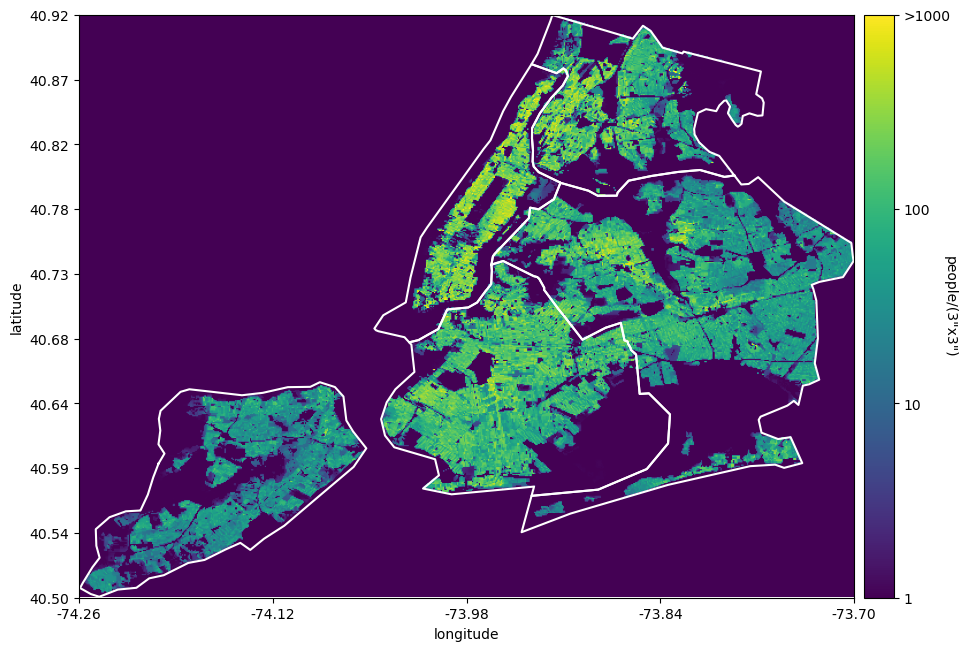

In [ ]:
transform = region_transform
for polygon in admin_polygons.values(): 
    transformed_poly = [transform.__invert__() * coords for coords in polygon.exterior.coords]
    xs = [coords[0] for coords in transformed_poly] + [transformed_poly[0][0]]
    ys = [coords[1] for coords in transformed_poly] + [transformed_poly[0][1]]
    ax.plot(xs, ys, 'w-')
    #ax.fill_between(xs, ys, alpha=0.5, facecolor='black')
ax.set_xlim(left=0)
ax.set_xlim(right=width)
ax.set_ylim(bottom=height)
ax.set_ylim(top=0)
fig

In [ ]:
#fig.savefig('london_densities.png', bbox_inches="tight")

In [ ]:
show_stats(dataset, region_polygon.geoms)

population: 8.33 million
max:        2677 people / pixel
area:       924.22 km^2
density:    9016.65 people/km^2


In [ ]:
show_stats(dataset, admin_polygons.values())

population: 8.33 million
max:        2677 people / pixel
area:       924.22 km^2
density:    9016.65 people/km^2


In [ ]:
clipping_region = admin_polygons.values()
with rasterio.open(raster_filepath) as src:
    clipped_img, clipped_transform = rasterio.mask.mask(src, clipping_region, crop=True)
    clipped_img[clipped_img < 0] = 0

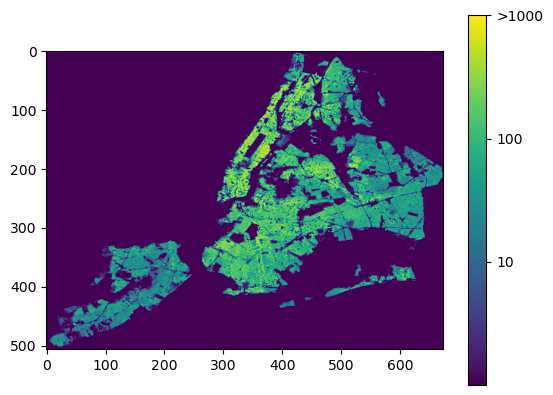

In [ ]:
img = clipped_img[0, :, :]
fig, ax = plt.subplots()
vmax = np.log10(1000) # 3.5 
cax = ax.imshow(np.log10(img + 1), vmax=vmax)
cbar = fig.colorbar(cax)

ticks = np.log10([10, 100, 1000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
#ticks = np.arange(0, 3.6, 1.0)
#tick_labels = 10 ** ticks

cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

## Gaza

In [ ]:
geojson_filepath = 'data/geoBoundaries-PSE-ADM1-all/geoBoundaries-PSE-ADM1.geojson'
with open(geojson_filepath, 'r') as f:
    palestine_data = json.load(f)
    
gaza_features = filter_features(palestine_data, 'shapeName', 'Gaza')
gaza_polygon = get_polygons(gaza_features)['Gaza']
palestine_polygons = get_polygons(palestine_data['features'])

In [ ]:
region_polygon.bounds

(-74.26061251699997, 40.496111205000034, -73.70002135199996, 40.91758530000004)

In [ ]:
raster_palestine_filepath = 'data/pse_ppp_2020_constrained.tif' # population counts
#raster_palestine_filepath = 'data/pse_pd_2020_1km_UNadj.tif' # population density
with rasterio.open(raster_palestine_filepath) as src:
    boundaries =  [gaza_polygon]
    #boundaries = palestine_polygons # Israel only
    clipped_img, clip_transform = rasterio.mask.mask(src, boundaries, crop=True)
    clipped_img[clipped_img < 0] = 0
    print('----- Gaza -----')
    show_stats(src, [gaza_polygon])
    print('----- West Bank + Gaza -----')
    show_stats(src, palestine_polygons.values())

#boundary = box(-0.6, 51.3, 0.3, 51.7) # London, UK
#boundary = box(27.4, -25.8, 28.6, -26.6) # Joburg, South Africa
#boundary = box(27, -25, 29, -27) # Joburg and Pretoria, South Africa
#boundary = box(1.85, 48.65, 2.6, 49.05) # Paris, France
#boundary = box(120.5, 14.3, 121.2,14.8) # Manila, Philipines
boundary = box(-74.4, 40.5, -73.7, 40.92) # New York, USA
#boundary = box(*region_polygon.bounds)
with rasterio.open(raster_filepath) as src:
    base_image, base_transform = rasterio.mask.mask(src, [boundary], crop=True)
    base_image[base_image < 0] = 0
    print('----- Region -----')
    show_stats(src, [boundary])
    print('----- Admin boundaries -----')
    show_stats(src, admin_polygons.values())

----- Gaza -----
population: 2.16 million
max:        615 people / pixel
area:       366.04 km^2
density:    5889.75 people/km^2
----- West Bank + Gaza -----
population: 5.62 million
max:        615 people / pixel
area:       6024.66 km^2
density:    932.31 people/km^2
----- Region -----
population: 11.76 million
max:        2677 people / pixel
area:       2761.66 km^2
density:    4257.38 people/km^2
----- Admin boundaries -----
population: 8.33 million
max:        2677 people / pixel
area:       924.22 km^2
density:    9016.65 people/km^2


In [ ]:
(base_image.shape, clipped_img.shape)

((1, 505, 841), (1, 446, 408))

In [ ]:
clip_height, clip_width = clipped_img.shape[1:3]
base_height, base_width = base_image.shape[1:3]

# For Israel only
long_min, lat_min, long_max, lat_max = MultiPolygon(palestine_polygons.values()).bounds
gaza_origin = base_transform.__invert__() * (long_min, lat_max)
gaza_origin = np.floor(gaza_origin).astype(int)

# otherwise
gaza_origin = (0, np.floor((base_height - clip_height)/ 2).astype(int)) # far left, middle

insert other image in `base_image`

In [ ]:
img_combined = base_image[0, :, :]
j0, i0 = gaza_origin

if j0 < 0:
    clipped_img = clipped_img[:, :, -(j0):]
    clip_height, clip_width = clipped_img.shape[1:3] 
    j0 = 0
    
img_combined[i0:(i0 + clip_height), j0:(j0 + clip_width)] = clipped_img
## OR
# for i in range(clip_height):
#     for j in range(clip_width):
#         if clipped_img[0, i, j] > 0:
#             img_combined[i0 + i, j0 + j] = clipped_img[0, i, j] 

# img_downscaled = block_reduce(img_combined, block_size=5, func=np.sum)
# print(img_combined.sum(), img_downscaled.sum(), img_downscaled.sum()/img_combined.sum())           

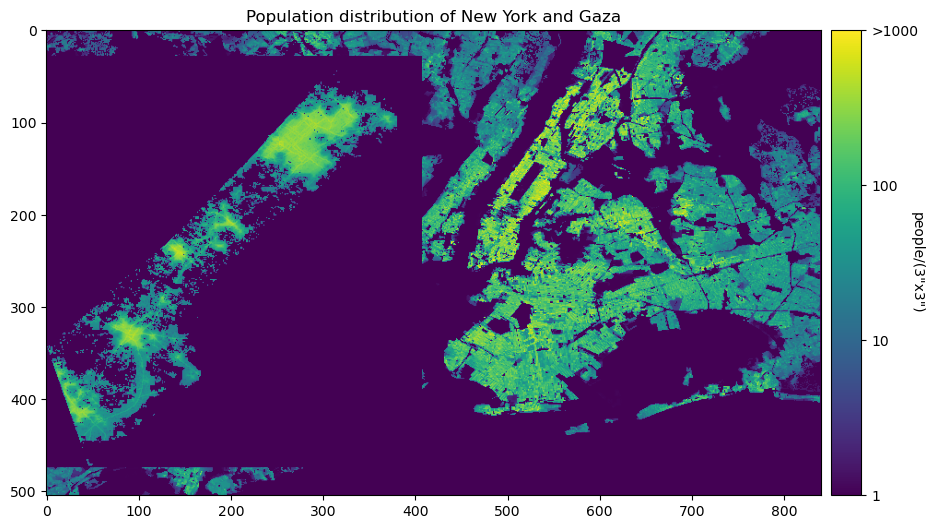

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Population distribution of New York and Gaza')
vmax = np.log10(1_000)
cmap = plt.get_cmap('viridis') #, 10)
img_axis = ax.imshow(np.log10(img_combined + 1), vmax=vmax, cmap=cmap)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = fig.colorbar(img_axis, cax)
#cbar.set_label('people/km^2', rotation=270) # density
cbar.set_label('people/(3\"x3\")', rotation=270) 
ticks = np.log10([1, 10, 100, 1000])
tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
tick_labels[-1] = '>' + tick_labels[-1]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

Set axis units

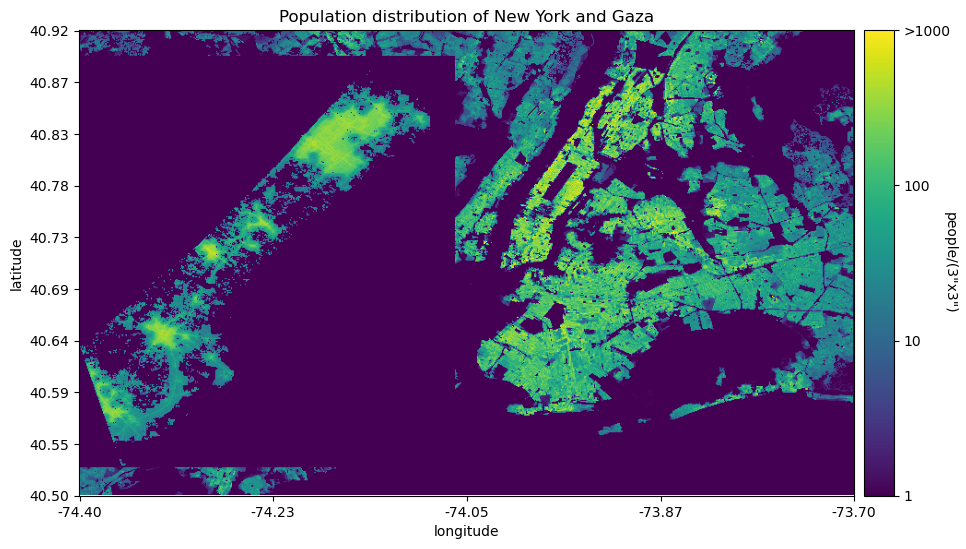

In [ ]:
height, width = img_combined.shape
## longitude / latitude
long_min, lat_max = base_transform * (0, 0)
long_max, lat_min = base_transform * (width, height)
num_steps = 10
x_ticks = np.linspace(0, width, 5)
x_ticklabels = [f'{x:.2f}' for x in np.linspace(long_min, long_max, 5)]
y_ticks = np.linspace(0, height, num_steps)
y_ticklabels = reversed([f'{x:.2f}' for x in np.linspace(lat_min, lat_max, num_steps)])
x_unit = 'longitude'
y_unit = 'latitude'

### km
# long_scale, lat_scale = get_scales(img_combined.shape, boundary)
# x_ticklabels = np.arange(0, lat_scale * width, 10_000)
# x_ticks = np.floor(x_ticklabels / lat_scale)
# x_ticklabels /= 1000
# y_ticklabels = np.arange(0, long_scale * height, 10_000)
# y_ticks = np.floor(y_ticklabels / long_scale)
# y_ticklabels /= 1000
# x_unit = 'km'
# y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
fig

Gaza boundaries

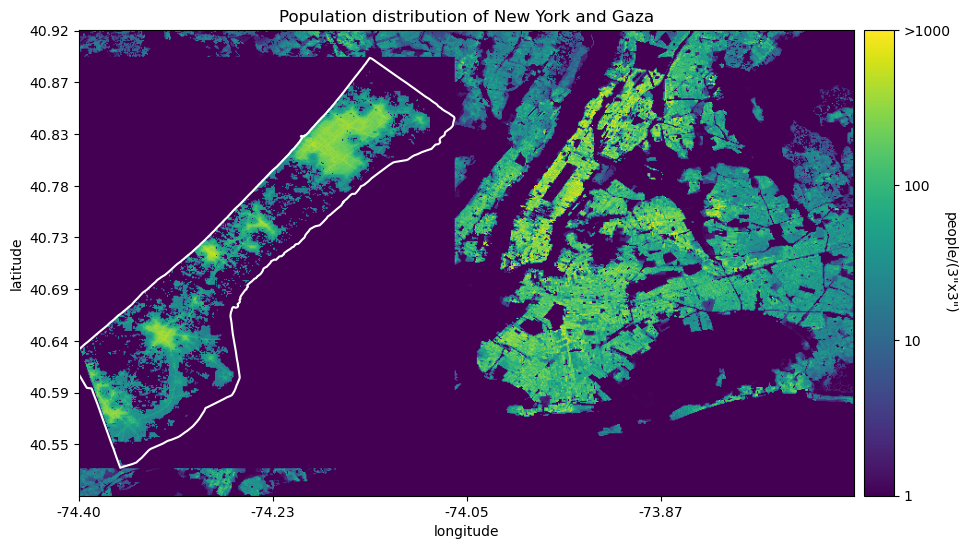

In [ ]:
transform = base_transform
for polygon in [gaza_polygon]:
    #polygon = gaza_polygon
    origin = transform * (0, i0)
    xoff = origin[0] - clip_transform.c
    yoff = origin[1] - clip_transform.f 
    polygon = affinity.translate(polygon, xoff=xoff, yoff=yoff) # ignore for Israel
    polygon = [transform.__invert__() * coords for coords in polygon.exterior.coords]
    xs = [coords[0] for coords in polygon]
    ys = [coords[1] for coords in polygon]
    ax.plot(xs, ys, 'w-')
    ax.set_xlim(left=0)
fig

admin boundaries

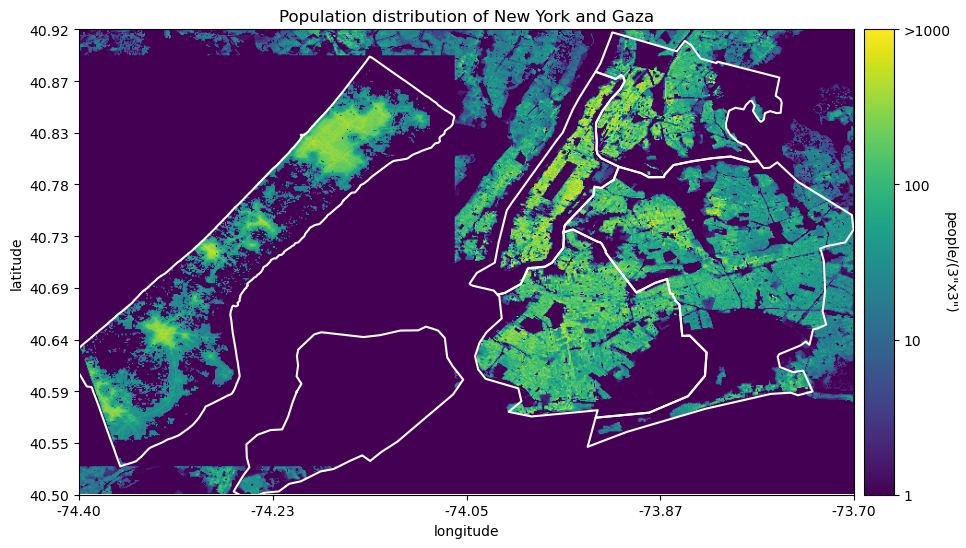

In [ ]:
transform = base_transform
for polygon in admin_polygons.values(): 
    transformed_poly = [transform.__invert__() * coords for coords in polygon.exterior.coords]
    xs = [coords[0] for coords in transformed_poly] + [transformed_poly[0][0]]
    ys = [coords[1] for coords in transformed_poly] + [transformed_poly[0][1]]
    ax.plot(xs, ys, 'w-')
ax.set_xlim(left=0)
ax.set_xlim(right=width)
ax.set_ylim(bottom=height)
ax.set_ylim(top=0)
fig

In [ ]:
fig.savefig('ny_gaza_distribution.png', bbox_inches="tight")